# Benoit's Problem with various RTO Algorithms

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt

# 0. Benoit's Problem

In [ ]:

# Actual Plant System
def Benoit_System_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2 + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2. + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def con1_system_tight(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def Benoit_System_noiseless_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1]   # + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_noiseless_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2  # + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2.  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

def con1_system_tight_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1]  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

## Diagram for Benoit's Problem

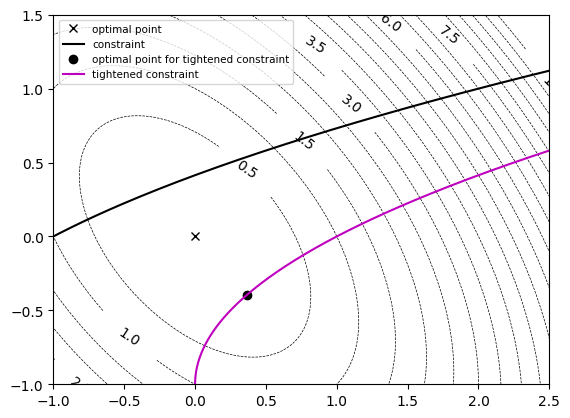

In [ ]:
# Plot for objective function 
def plant_drawing(is_constraint,is_tight_constraint):
        delta = 0.01
        x = np.arange(-3.5, 3.5, delta)
        y = np.arange(-3.5, 3.5, delta)
        u = np.meshgrid(x, y)
        levels = np.linspace(0,10,21)

        CS1 = plt.contour(u[0],u[1],Benoit_System_noiseless_1(u),levels,colors='k',linestyles = "dashed",linewidths = 0.5)
        plt.clabel(CS1,inline=True)
        plt.axis((-1, 2.5, -1, 1.5))

        if is_constraint == True:
                # Plot for optimal value for optimization with constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_noiseless(u)}) 
                result = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})
                
                ustar = result.x
                fstar = result.fun
                plt.plot(ustar[0],ustar[1],'kx')
                
                # Plot for constraint
                uc0 = 1. + x ** 2 + 2. * x - 2.
                constraint1 = plt.plot(uc0,x,'k')

        if is_tight_constraint == True:

                # Plot for optimal value for optimization with tightened constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_tight_noiseless(u)}) 
                result_tight = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})

                ustar = result_tight.x
                fstar = result_tight.fun
                plt.plot(ustar[0],ustar[1],'ko')

                # Plot for tightened constraint

                uc0t = 1. + x ** 2 + 2. * x
                constraint2 = plt.plot(uc0t,x,'m')

# plant_drawing(is_constraint=True,is_tight_constraint=False)
plant_drawing(is_constraint=True,is_tight_constraint=True)
plt.legend(["optimal point",
            "constraint",
            'optimal point for tightened constraint',
            'tightened constraint'],
                fontsize = 7.5)
plt.show()

# 2. Modifier Adaptation

## A. Benoit Model

In [ ]:
# Plant Model 
def Benoit_Model(u,theta,modifier):

    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2 + np.sum(modifier[2] * u)
    return f

def con1_model(u,u0,theta,modifier):

    g1 = 1. - theta[2]*u[0] + theta[3]*u[1] ** 2 + modifier[0] + np.sum(modifier[1]*(u-u0))
    return -g1


## B. Optimization on Cost Function

In [ ]:
def cost_optimize(u0,theta,modifier):

    con = ({'type': 'ineq',
            'fun': lambda u: con1_model(u,u0,theta,modifier)})
    
    result = minimize((Benoit_Model),
                    u0,
                    constraints= con,
                    method='SLSQP',
                    options= {'ftol': 1e-9},
                    args= (theta,modifier))
    
    return result.x,result.fun

In [ ]:
# Test
u0 = np.array([10,0]) # Initial guess for optimization algorithm
modifier = np.array([-0.6834536267626328,[-0.25      ,  0.74531547],[0.19976909, 0.19976909]],dtype=object) 
theta = np.array([0.5,0.5,0.5,0.5])

u,fun = cost_optimize(u0,theta,modifier)

print(f"optimal input: {u}, optimal output: {fun}")

optimal input: [ 3.39098837 -0.65105543], optimal output: 6.50869155160146


## C. Modifier Adaptation

In [ ]:
# gradient modifier
def gradient_estimation(u,fun):
    # step
    du = np.sqrt(1e-3) # np.finfo

    # Predicted gradient from real plant
    gradient_u0 = (fun(u+[du,0]) - fun(u))/du
    gradient_u1 = (fun(u+[0,du]) - fun(u))/du
    gradient = [gradient_u0,gradient_u1]
    
    return gradient

# Modifier Update
def modifier_update(u,u0,theta,modifier,plant_fun,plant_con1):
    
    # Calculate relavent bias and gradients:
    gradient_cost_p = gradient_estimation(u,plant_fun)
    ## Gradient of plant constraint function
    gradient_con1_p = gradient_estimation(u,plant_con1)
    ## Gradient of model cost function
    gradient_cost_m = approx_fprime(u,Benoit_Model,np.sqrt(1e-3),theta,modifier)
    ## Gradient of model constraint function
    gradient_con1_m = approx_fprime(u,con1_model,np.sqrt(1e-3),u0,theta,modifier)
    ## Gradient of plant cost function

    # Calculate difference between plant and model
    epsil = -(plant_con1(u) - con1_model(u,u0,theta,modifier))
    lamda_0 = -1*(gradient_con1_p - gradient_con1_m)
    lamda_1 = gradient_cost_p - gradient_cost_m 

    return [epsil,lamda_0,lamda_1]

# Modifier Adaptation
def adaptation(u,u0,theta,modifier,plant_fun,plant_con1,K):
    new_modifier = modifier_update(u,u0,theta,modifier,plant_fun,plant_con1)
    I = np.identity(np.shape(modifier)[0])

    for i in range(np.shape(modifier)[0]):
        modifier[i] = (I - K)[i,i]*modifier[i] + K[i,i]*new_modifier[i]

    return modifier

In [ ]:
# Test
## Variable
u = np.array([-0.20316229, -0.80316225])
u0 = np.array([-1,-1]) 
modifier = [1.4000000000000001,[0.5,0.80316228],[0.20316228,0.20316228]]
modifier = np.array([np.array(x) for x in modifier],dtype=object)
theta = np.array([0.5,0.5,0.5,0.5])
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_tight_noiseless
K = np.identity(np.shape(modifier)[0])*0.2

# Modifier Adaptation
modifier = adaptation(u,u0,theta,modifier,plant_fun,plant_con1,K)
print("New Modifier:")
print(modifier)


New Modifier:
[0.4922559867664922 array([0.2      , 0.7244272])
 array([-0.07620526, -0.07620526])]


## D. Overall Algorithm

### I.Plant System: "Benoit_System_noiseless_1" plant system with "con1_system_noiseless" constraint

In [ ]:
uk = np.array([1,1]) 
modifier = [1,[1,1],[1,1]]
modifierk = np.array([np.array(x) for x in modifier],dtype=object)
theta = np.array([0.5,0.5,0.5,0.5])
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_noiseless
K = np.identity(np.shape(modifierk)[0])*0.2


for i in range(5):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,uk,theta,modifierk,plant_fun,plant_con1,K)

    uk = uk_1
    modifierk = modifierk_1

    print(f"optimal input: {uk_1}, optimal output: {fun} \n modifier: {modifierk_1}")

optimal input: [-1. -1.], optimal output: -1.0 
 modifier: [0.8 array([0.5       , 0.80316228]) array([0.20316228, 0.20316228])]
optimal input: [-0.28702668 -0.80316263], optimal output: 0.14224191626554675 
 modifier: [-0.2509711656288086 array([0.2       , 0.72442712])
 array([-0.09297822, -0.09297822])]
optimal input: [ 3.75926961 -0.6626007 ], optimal output: 6.997651106401173 
 modifier: [-1.3298631981132287 array([0.02      , 0.70529841])
 array([0.56670913, 0.56670913])]
optimal input: [-0.37810551 -0.60580322], optimal output: -0.3026094010564324 
 modifier: [-1.357191236533521 array([-0.088     ,  0.70518068])
 array([0.14640601, 0.14640601])]
optimal input: [-0.11844039 -0.17177513], optimal output: -0.020721885427756243 
 modifier: [-1.3248736235536016 array([-0.1528    ,  0.79191566])
 array([0.03296278, 0.03296278])]


### II.Plant System: "Benoit_System_noiseless_1" plant system with "con1_system_tight_noiseless" constraint

In [ ]:
uk = np.array([1,1]) 
modifier = [1,[1,1],[1,1]]
modifierk = np.array([np.array(x) for x in modifier],dtype=object)
theta = np.array([0.5,0.5,0.5,0.5])
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_tight_noiseless
K = np.identity(np.shape(modifierk)[0])*0.2

for i in range(5):
    uk_1,fun = cost_optimize(uk,theta,modifierk)
    modifierk_1 = adaptation(uk_1,uk,theta,modifierk,plant_fun,plant_con1,K)

    uk = uk_1
    modifierk = modifierk_1

    print(f"optimal input: {uk_1}, optimal output: {fun} \n modifier: {modifierk_1}")

optimal input: [-1. -1.], optimal output: -1.0 
 modifier: [1.2000000000000002 array([0.5       , 0.80316228])
 array([0.20316228, 0.20316228])]
optimal input: [-0.20316227 -0.80316227], optimal output: 0.13872508582202128 
 modifier: [0.37225598094208345 array([0.2       , 0.72442719])
 array([-0.07620526, -0.07620526])]
optimal input: [ 5.77708226 -0.68440142], optimal output: 16.533453268708662 
 modifier: [-0.8376911744822625 array([0.02      , 0.70093831])
 array([0.97597529, 0.97597529])]
optimal input: [ 0.5894085  -0.76548255], optimal output: 0.29483903892790475 
 modifier: [-0.7770349537015446 array([-0.088     ,  0.67062875])
 array([0.55353264, 0.55353264])]
optimal input: [ 0.95893435 -0.63784914], optimal output: 0.8409344423518574 
 modifier: [-0.7871841823010275 array([-0.1528   ,  0.6779697])
 array([0.3994989, 0.3994989])]


### Actual Optimized Input and Output


In [ ]:
u0 = [2,1] 
con = ({'type': 'ineq', 
        'fun': lambda u: con1_system_noiseless(u)}) 
result = minimize(Benoit_System_noiseless_1,
                u0,
                constraints= con,
                method='SLSQP',
                options={'ftol': 1e-9})

u = result.x
fun = result.fun

print(f"optimal input: {u}, optimal output: {fun}")

optimal input: [-4.97322951e-09 -4.97201070e-09], optimal output: 7.418085245734631e-17
